In [3]:
import os, itertools, multiprocessing
# os.environ['OMP_NUM_THREADS']="1"
import numpy as np
import pandas as pd
import scipy.stats as stat
import seaborn as sns
import matplotlib.pyplot as plt
# from hmmviz import TransGraphy
import networkx as nx
from sklearn.cluster import KMeans
import ipywidgets as widgets
from ipywidgets import interactive
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
import scipy


## Matrix of Transitions

In [4]:
graph = np.zeros((15, 15))
graph[0, (1, 2, 3, 14)] = 1
graph[1, (0, 2, 3, 4)] = 1
graph[2, (0, 1, 3, 4)] = 1
graph[3, (0, 1, 2, 4)] = 1
graph[4, (1, 2, 3, 5)] = 1
graph[5, (4, 6, 7, 8)] = 1
graph[6, (5, 7, 8, 9)] = 1
graph[7, (5, 6, 8, 9)] = 1
graph[8, (5, 6, 7, 9)] = 1
graph[9, (6, 7, 8, 10)] = 1
graph[10, (9, 11, 12, 13)] = 1
graph[11, (10, 12, 13, 14)] = 1
graph[12, (10, 11, 13, 14)] = 1
graph[13, (10, 11, 12, 14)] = 1
graph[14, (11, 12, 13, 0)] = 1

# graph[0, 2] = 1
# graph[2, 0] = 1

# graph[1, 2] = 1

In [5]:
graph_lattice = np.zeros((15, 15))
graph_lattice[0, (1, 2, 3, 12)] = 1
graph_lattice[1, (0, 2, 4, 13)] = 1
graph_lattice[2, (0, 1, 5, 14)] = 1
graph_lattice[3, (0, 4, 5, 6)] = 1
graph_lattice[4, (1, 3, 5, 7)] = 1
graph_lattice[5, (2, 3, 4, 8)] = 1
graph_lattice[6, (3, 7, 8, 9)] = 1
graph_lattice[7, (4, 6, 8, 10)] = 1
graph_lattice[8, (5, 6, 7, 11)] = 1
graph_lattice[9, (6, 10, 11, 12)] = 1
graph_lattice[10, (7, 9, 11, 13)] = 1
graph_lattice[11, (8, 9, 10, 14)] = 1
graph_lattice[12, (9, 13, 14, 0)] = 1
graph_lattice[13, (10, 12, 14, 1)] = 1
graph_lattice[14, (10, 11, 13, 2)] = 1

In [6]:
# sns.heatmap(graph_lattice), plt.show()
# sns.heatmap(graph)
graph_with_remote = np.zeros((12, 12))
graph_with_remote[0, (1, 2)] = 1 
graph_with_remote[1, (0, 3, 4)] = 1
graph_with_remote[2, (0, 3, 4)] = 1
graph_with_remote[3, (1, 2, 4, 5)] = 1
graph_with_remote[4, (1, 2, 3, 5)] = 1
graph_with_remote[5, (3, 4, 6)] = 1
graph_with_remote[6, (5, 7, 8)] = 1
graph_with_remote[7, (6, 8, 9, 10)] = 1
graph_with_remote[8, (6, 7, 9, 10)] = 1
graph_with_remote[9, (7, 8, 11)] = 1
graph_with_remote[10, (7, 8, 11)] = 1
graph_with_remote[11, (9, 10)] = 1



In [7]:
def plot_graph(graph):
    G = nx.Graph() 
    for i in range(graph.shape[0]):
        for j in range(graph.shape[1]):
            if graph[i][j]:
                G.add_edge(i, j)

    nx.draw(G, with_labels = True)
    plt.show()


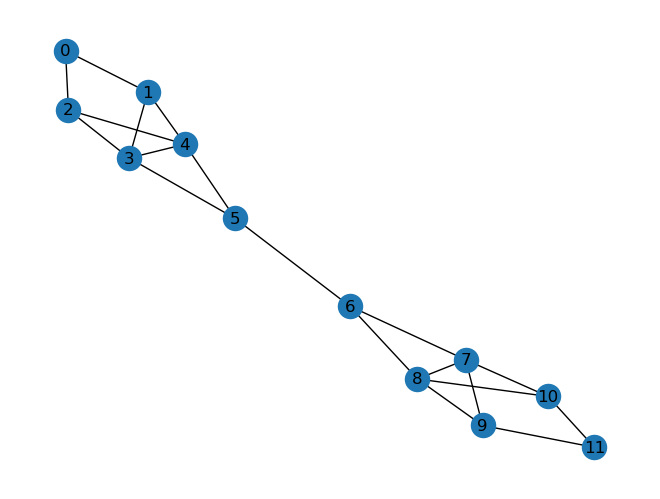

In [9]:
plot_graph(graph_with_remote)

## Generate different paths

In [10]:
def random_walk(graph):
    #Random Walk
    start_state = np.random.choice(range(8))
    path_length = 1000
    current_state = start_state
    path = np.zeros(path_length)
    for i in range(path_length):
        path[i] = current_state
        neighbour_states = np.where(graph[current_state])[0]
        next_state = np.random.choice(neighbour_states)
        current_state = next_state
    return path
path = random_walk(graph_lattice)
        

In [11]:
#Eulerian Walk
start_state = np.random.choice(np.arange(16))
path_length = 10000

def find_euler(adj_list, start_state):
    euler_path = []
    stack = []
    stack.append(start_vertex)
    while len(stack) > 0:
        top = stack[-1]
        if len(adj_list[int(top)]) == 0:
            euler_path.append(top)
            stack = stack[:-1]
        else:
            new_vertex = np.random.choice(adj_list[str(top)])
            adj_list[str(top)].remove(new_vertex)
            adj_list[str(new_vertex)].remove(top)
            stack.append(new_vertex)
    return euler_path


## SR Learning

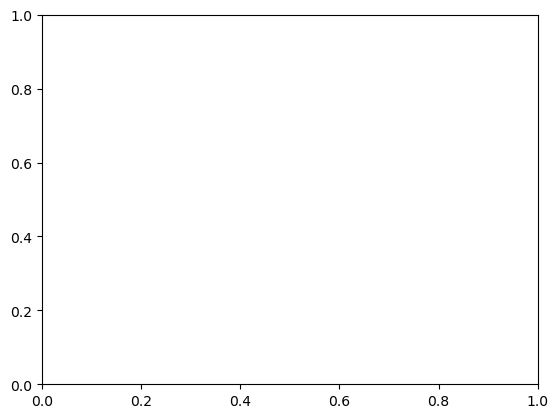

In [25]:
fig, ax = plt.subplots()

def draw_SR_categories(path, cutoff_point, alpha = 0.1, gamma = 0.1, num_nodes = 15, ax = ax, plot = True):
    ax.clear()
    SR = np.random.uniform(0, 1, size=(num_nodes, num_nodes))
    start_state = np.random.choice(np.arange(8))
    current_state = start_state    
    cmap = plt.cm.rainbow


    for i, observed_state in enumerate(path[:cutoff_point]):

        expected_probs = SR[current_state]
        one_hot_obs = np.zeros(num_nodes)
        one_hot_obs[int(observed_state)] = 1

        SR_delta = one_hot_obs + gamma*SR[int(observed_state), :] - expected_probs

        SR[current_state, :] = SR[current_state, :] + alpha*SR_delta
        SR[current_state, :] = SR[current_state, :]/sum(SR[current_state])
        current_state = int(observed_state)    



    G = nx.Graph() 


    kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(SR)
#     gm = GaussianMixture(n_components=3, random_state=0, reg_covar=0.05).fit(SR)
    node_color = []
    node_transparency = []
    clusters_assigned = kmeans.predict(SR)
    centroids = kmeans.cluster_centers_
    
#     print(distances)

#     print(prob, cluster)
#     print(prob)
    for node in range(15):
        node_distance = np.linalg.norm(SR[node] - centroids, axis=1)

#         node_confidences = np.exp(-node_distance / 2) / np.sum(np.exp(-node_distance / 2), axis=0)
        node_confidences = scipy.special.softmax(1/node_distance)
        node_transparency.append(node_confidences)
        
        

        if kmeans.labels_[node] == 0:
#         if cluster[node] == 0:
            node_color.append('red')
        elif kmeans.labels_[node] == 1:
#         elif cluster[node] == 1:
            node_color.append('green')
        else:
            node_color.append('blue')
        
        G.add_node(str(node))

    # print(node_transparency)

    if plot:
        for i in range(SR.shape[0]):
            for j in range(SR.shape[1]):
                G.add_edge(str(i), str(j), weight = SR[i][j])    
                
        edges = G.edges
        weights = [SR[int(u)][int(v)] for u,v in edges]

        node_pos = nx.spring_layout(G)
        node_labels = np.arange(15).astype(str)

        nx.draw_networkx_nodes(G, pos=node_pos, node_color=node_transparency,  nodelist=G.nodes, ax = ax)
        nx.draw_networkx_edges(G, pos=node_pos, width=weights, ax = ax)
        nx.draw_networkx_labels(G, pos = node_pos, ax = ax)
        
        nx.draw(G, node_color=node_color, width = weights, with_labels = True, alpha=0.5)#, alpha = node_transparency)
    
    # plt.show()
    return SR

In [13]:
# from matplotlib.animation import FuncAnimation
# # figure, ax = plt.subplots()
# animation = FuncAnimation(fig, func = draw_SR_categories, frames=np.arange(1, 500, 25), interval = 500, repeat = True)
# animation.save('animation.gif')
# # plt.show()

c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


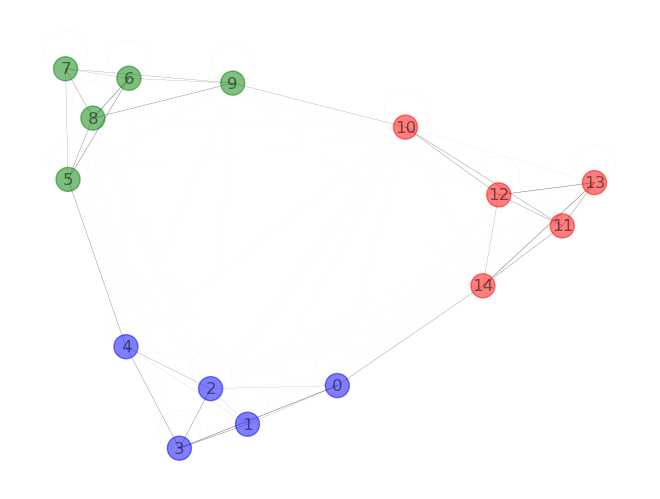

In [62]:
path = random_walk(graph)
SR = draw_SR_categories(path, 10000, alpha=.1, gamma=.1, plot = True)
# plt.show()

In [63]:
boundary_entropy = 0
nonboundary_entropy = 0
for node in range(15):
    if node%5 == 0  or node%5 == 4:
        boundary_entropy += -np.sum(SR[node]*np.log(SR[node]))/6
    else:
        nonboundary_entropy += -np.sum(SR[node]*np.log(SR[node]))/9

In [65]:
boundary_entropy

1.5367220225611065

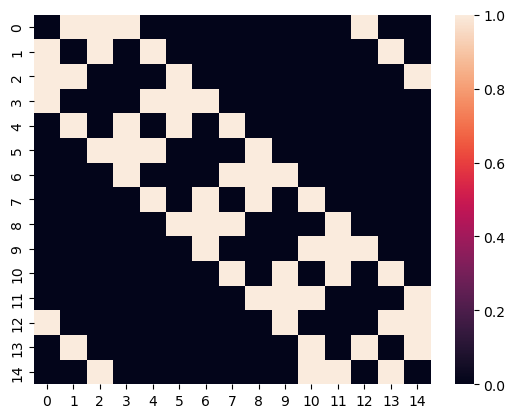

(<AxesSubplot: >, None, <AxesSubplot: >)

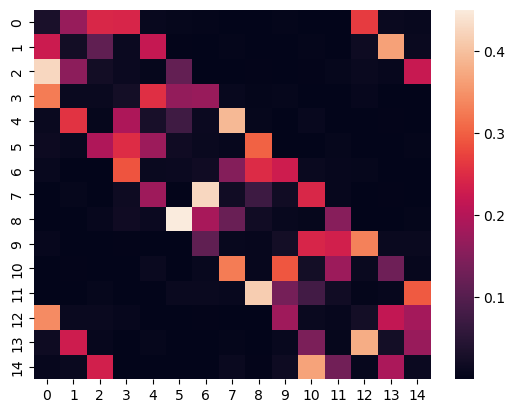

In [36]:
sns.heatmap(graph_lattice), plt.show(), sns.heatmap(SR)

In [29]:
def compute_entropies(params):
    modular_entropy = np.zeros(100)
    lattice_entropy = np.zeros(100)
    alpha = params[0]
    gamma = params[1]
    for e in range(100):
        path = random_walk(graph)
        SR = draw_SR_categories(path, 1000, alpha=alpha, gamma=gamma, plot=False)
        modular_entropy[e] = -np.sum(SR*np.log(SR))
        if e%100 == 0:
            print(modular_entropy[e])

        path = random_walk(graph_lattice)
        SR = draw_SR_categories(path, 1000)
        lattice_entropy[e] = -np.sum(SR*np.log(SR), alpha=alpha, gamma=gamma, plot=False)
        if e%100 == 0:
            print(lattice_entropy[e])
    return alpha, gamma, modular_entropy, lattice_entropy

In [30]:
params = itertools.product([0.01, 0.05, 0.1, 0.2, 0.5], [0.01, 0.05, 0.1, 0.2, 0.5])
p = multiprocessing.Pool()
entropies = p.map(compute_entropies, params)

24.634846373110353


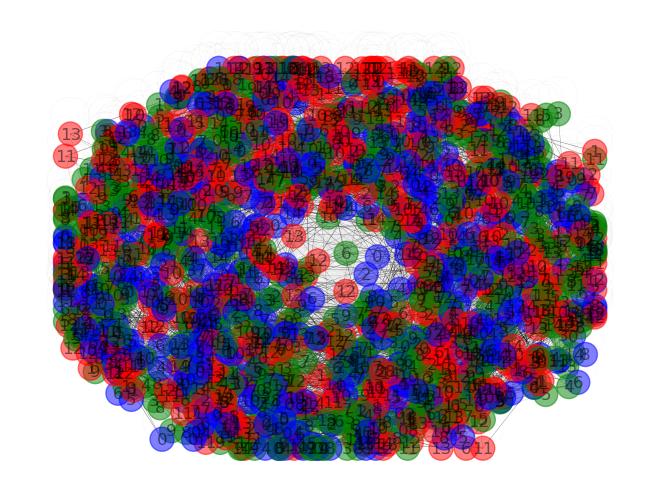

In [17]:
for e in range(100):
    path = random_walk(graph_lattice)
    SR = draw_SR_categories(path, 1000)
    lattice_entropy[e] = -np.sum(SR*np.log(SR))
    if e%100 == 0:
        print(lattice_entropy[e])

In [22]:
entropy_df = pd.DataFrame({'p_id': np.tile(np.arange(100), 2), 
                        'entropy': np.ravel([entropy, lattice_entropy]),
                        'graph type': np.repeat(['modular', 'lattice'], 100)
                        })
entropy_df

,p_id,entropy,graph type
0,0,21.825745,modular
1,1,22.451554,modular
2,2,22.557893,modular
3,3,22.454075,modular
4,4,22.234809,modular
...,...,...,...
195,95,24.118617,lattice
196,96,24.303905,lattice
197,97,24.187443,lattice
198,98,24.473766,lattice


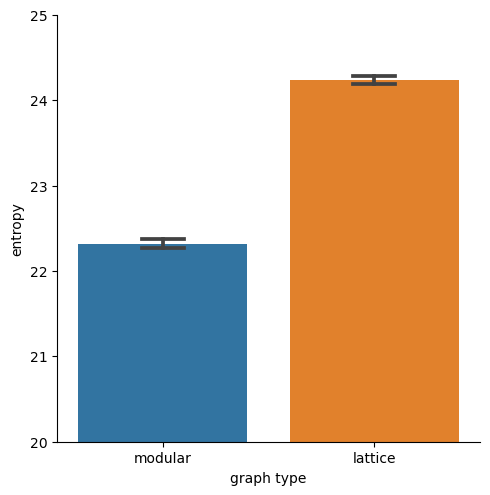

In [25]:
g = sns.catplot(x = 'graph type', y = 'entropy', kind = 'bar', capsize = 0.2, data = entropy_df)
g.set(ylim = (20, 25))

In [111]:
node = 10
sum(-SR[node]*np.log(SR[node]))

2.3650881296621584

In [10]:
cutoff_point = widgets.IntSlider(
    value=5,
    min=0,
    max=2000,
    step=5,
    description='Cutoff Point',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [11]:
alpha = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=1,
    step=0.001,
    description='Alpha',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f'
)

In [12]:
gamma = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=1,
    step=0.001,
    description='Gamma',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f'
)

In [13]:
slider_controls = interactive(draw_SR_categories, 
                 cutoff_point=cutoff_point, 
                 alpha=alpha,
                 gamma = gamma, num_nodes = 15)
display(slider_controls)

interactive(children=(IntSlider(value=5, continuous_update=False, description='Cutoff Point', max=2000, step=5…

In [ ]:
for cp in np.arange(1, 500, 10):
    draw_SR_categories(cutoff_point=cp, alpha=0.1, gamma=0.1, num_nodes=15)
    plt.pause(0.01)
plt.show()

[array([0.29329587, 0.30281064, 0.4038935 ]), array([0.25819462, 0.28786838, 0.453937  ]), array([0.25393163, 0.33435793, 0.41171044]), array([0.29963336, 0.38297079, 0.31739585]), array([0.2524241 , 0.44164054, 0.30593536]), array([0.50255089, 0.24518857, 0.25226055]), array([0.25822501, 0.32968224, 0.41209275]), array([0.26430799, 0.29054467, 0.44514734]), array([0.26404456, 0.43468909, 0.30126636]), array([0.2808309 , 0.33787856, 0.38129054]), array([0.27083806, 0.38394796, 0.34521398]), array([0.28503936, 0.32545408, 0.38950656]), array([0.48282179, 0.26840925, 0.24876896]), array([0.25616705, 0.28485775, 0.4589752 ]), array([0.31837477, 0.36758342, 0.31404182])]


c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


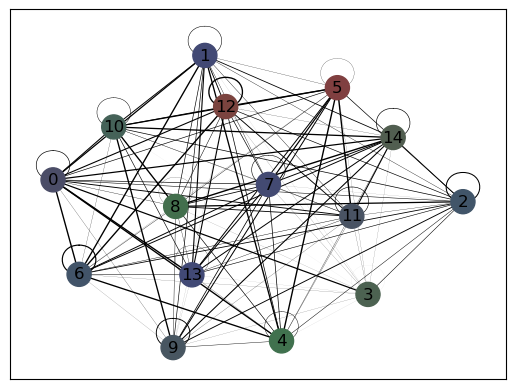

In [165]:
# Compare paths in a task and ask for the likelihood of seeing each path.
# Equate probabilities. 

[ 95.56262148  93.8089131  102.91891488  89.02876225 104.16480486
 300.90286772 295.94563369 301.48164261 309.607328   301.62030832
 497.92485366 504.2303687  491.36499005 501.03026407 498.07699632]


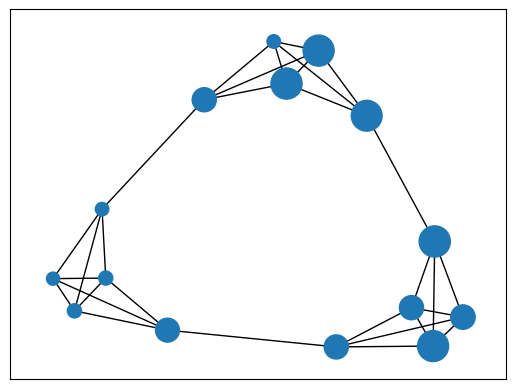

In [274]:
rewards = np.concatenate((np.random.normal(100, 5, size=5), np.random.normal(300, 5, size=5), np.random.normal(500, 5, size=5)))# rewards = np.arange(1, 16)*50
print(rewards)
G = nx.Graph() 
for i in range(graph.shape[0]):
    for j in range(graph.shape[1]):
        if graph[i][j]:
            G.add_edge(i, j)
            
node_pos = nx.spring_layout(G)
node_labels = np.arange(15).astype(str)

nx.draw_networkx_nodes(G, pos=node_pos,  nodelist=G.nodes, node_size=np.roll(rewards, -1))
nx.draw_networkx_edges(G, pos=node_pos)

In [249]:
def plot_learned_graphs(SR, kmeans):
    G = nx.Graph() 

    node_color = []
    node_transparency = []

    clusters_assigned = kmeans.predict(SR)
    centroids = kmeans.cluster_centers_
    
    for node in range(15):
        node_distance = np.linalg.norm(SR[node] - centroids, axis=1)

        node_confidences = scipy.special.softmax(1/node_distance)
        node_transparency.append(node_confidences)
        
        

        if kmeans.labels_[node] == 0:
            node_color.append('red')
        elif kmeans.labels_[node] == 1:
            node_color.append('green')
        else:
            node_color.append('blue')        
        G.add_node(str(node))

#     print(node_transparency)
    for i in range(SR.shape[0]):
        for j in range(SR.shape[1]-1):
            G.add_edge(str(i), str(j), weight = SR[i][j])                
    edges = G.edges
    weights = [SR[int(u)][int(v)] for u,v in edges]

    node_pos = nx.spring_layout(G)    
    node_labels = np.arange(15).astype(str)

    nx.draw_networkx_nodes(G, pos=node_pos, node_color=node_transparency,  nodelist=G.nodes, node_size=rewards)
    nx.draw_networkx_edges(G, pos=node_pos, width=weights)
    nx.draw_networkx_labels(G, pos = node_pos)
        
    plt.show()


In [250]:
def draw_SR_categories_rewards(cutoff_point, alpha, gamma, num_nodes=15):
    SR = np.random.uniform(0, 1, size=(num_nodes, num_nodes))
    start_state = np.random.choice(np.arange(num_nodes))
    current_state = start_state    
    cmap = plt.cm.rainbow


    for i, observed_state in enumerate(path[:cutoff_point]):

        expected_probs = SR[current_state]
        one_hot_obs = np.zeros(num_nodes)
        one_hot_obs[int(observed_state)] = 1

        SR_delta = one_hot_obs + gamma*SR[int(observed_state), :] - expected_probs

        SR[current_state, :] = SR[current_state, :] + alpha*SR_delta
        SR[current_state, :] = SR[current_state, :]/sum(SR[current_state])
        current_state = int(observed_state)    

        
    
    SR_with_rewards = np.hstack((SR, rewards[:, None]/np.max(rewards)))

    kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(SR_with_rewards)
    plot_learned_graphs(SR_with_rewards, kmeans)
    
    return SR_with_rewards, kmeans

In [253]:
# SR_with_rewards, kmeans = draw_SR_categories_rewards(700, 0.1, 0.1, 15)

In [251]:
slider_controls = interactive(draw_SR_categories_rewards, 
                 cutoff_point=cutoff_point, 
                 alpha=alpha,
                 gamma = gamma)
display(slider_controls)

interactive(children=(IntSlider(value=605, continuous_update=False, description='Cutoff Point', max=2000, step…

In [205]:
def update_rewards_or_transitions(new_cutoff_point, alpha, gamma, SR_with_rewards, kmeans, num_nodes=15, change = 'reward update'):

    
    if change == 'reward update':
        temp = rewards[2]
        rewards[2] = rewards[12]
        rewards[12] = temp
        
        start_state = np.random.choice(np.arange(num_nodes))
        current_state = start_state    
        cmap = plt.cm.rainbow


        for i, observed_state in enumerate(path[:new_cutoff_point]):

            expected_probs = SR[current_state]
            one_hot_obs = np.zeros(num_nodes)
            one_hot_obs[int(observed_state)] = 1

            SR_delta = one_hot_obs + gamma*SR[int(observed_state), :] - expected_probs

            SR[current_state, :] = SR[current_state, :] + alpha*SR_delta
            SR[current_state, :] = SR[current_state, :]/sum(SR[current_state])
            current_state = int(observed_state)    

            kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(SR_with_rewards)
            plot_learned_graphs(SR_with_rewards, kmeans)
        
    
    return SR_with_rewards, kmeans

C:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


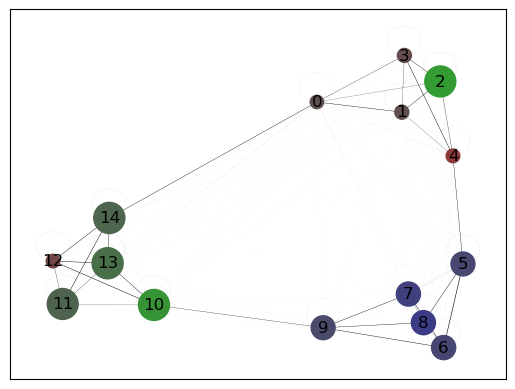

(array([[1.77234806e-02, 2.87997457e-01, 1.35749843e-01, 1.88751955e-01,
         1.82024879e-02, 1.15063970e-02, 1.01466334e-02, 1.09613560e-02,
         2.83218851e-03, 4.87779008e-03, 7.81222289e-03, 1.62228033e-02,
         8.00696755e-03, 1.17909478e-02, 2.67417470e-01, 9.27151193e+01],
        [3.77623381e-01, 2.11590980e-02, 2.54598407e-01, 1.80656618e-01,
         1.27412609e-01, 7.71205569e-03, 4.63468820e-03, 1.11868116e-03,
         4.07903078e-03, 2.74977044e-03, 1.98674185e-03, 2.65782521e-03,
         1.93497674e-03, 1.23831876e-03, 1.04377979e-02, 1.02799520e+02],
        [1.41468121e-01, 3.57652146e-01, 2.70621360e-02, 2.37927033e-01,
         2.02933770e-01, 1.03852331e-02, 2.42388079e-03, 2.46641426e-03,
         2.59830555e-03, 2.20649380e-03, 3.42106733e-03, 1.79075728e-03,
         1.38215359e-03, 1.27066780e-03, 5.01182097e-03, 4.97575959e+02],
        [1.02605077e-01, 1.24434747e-01, 3.97712348e-01, 2.44300995e-02,
         3.11527149e-01, 1.17121368e-02, 2.94951

In [208]:
update_rewards_or_transitions(300,  0.1, 0.1, SR_with_rewards, kmeans)


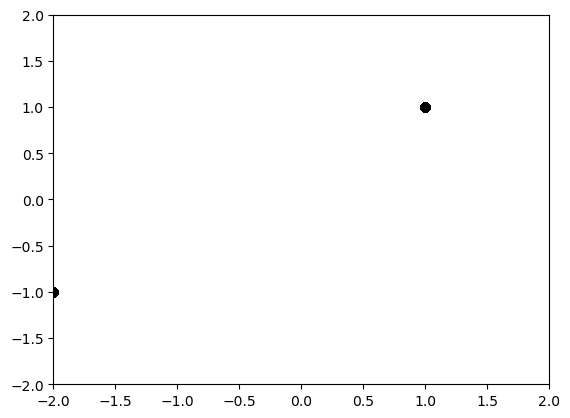

In [46]:
xmin = -2
xmax = 2
ymin = -2
ymax = 2
max_iterations = 100

# Create a figure and an axes
fig, ax = plt.subplots()

# Initialize the complex number z
z = 0

# Loop over the number of iterations
for i in range(max_iterations):

    # Calculate the next value of z
    z = z**2 + c

    # If z has diverged, stop the loop
    if abs(z) > 2:
        break

    # Plot the point (x, y)
    ax.plot([x, x], [y, y], 'o', color='black')

# Set the limits of the axes
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Show the plot
plt.show()

In [11]:
df_entropy = pd.read_csv('results/df_entropy.csv')


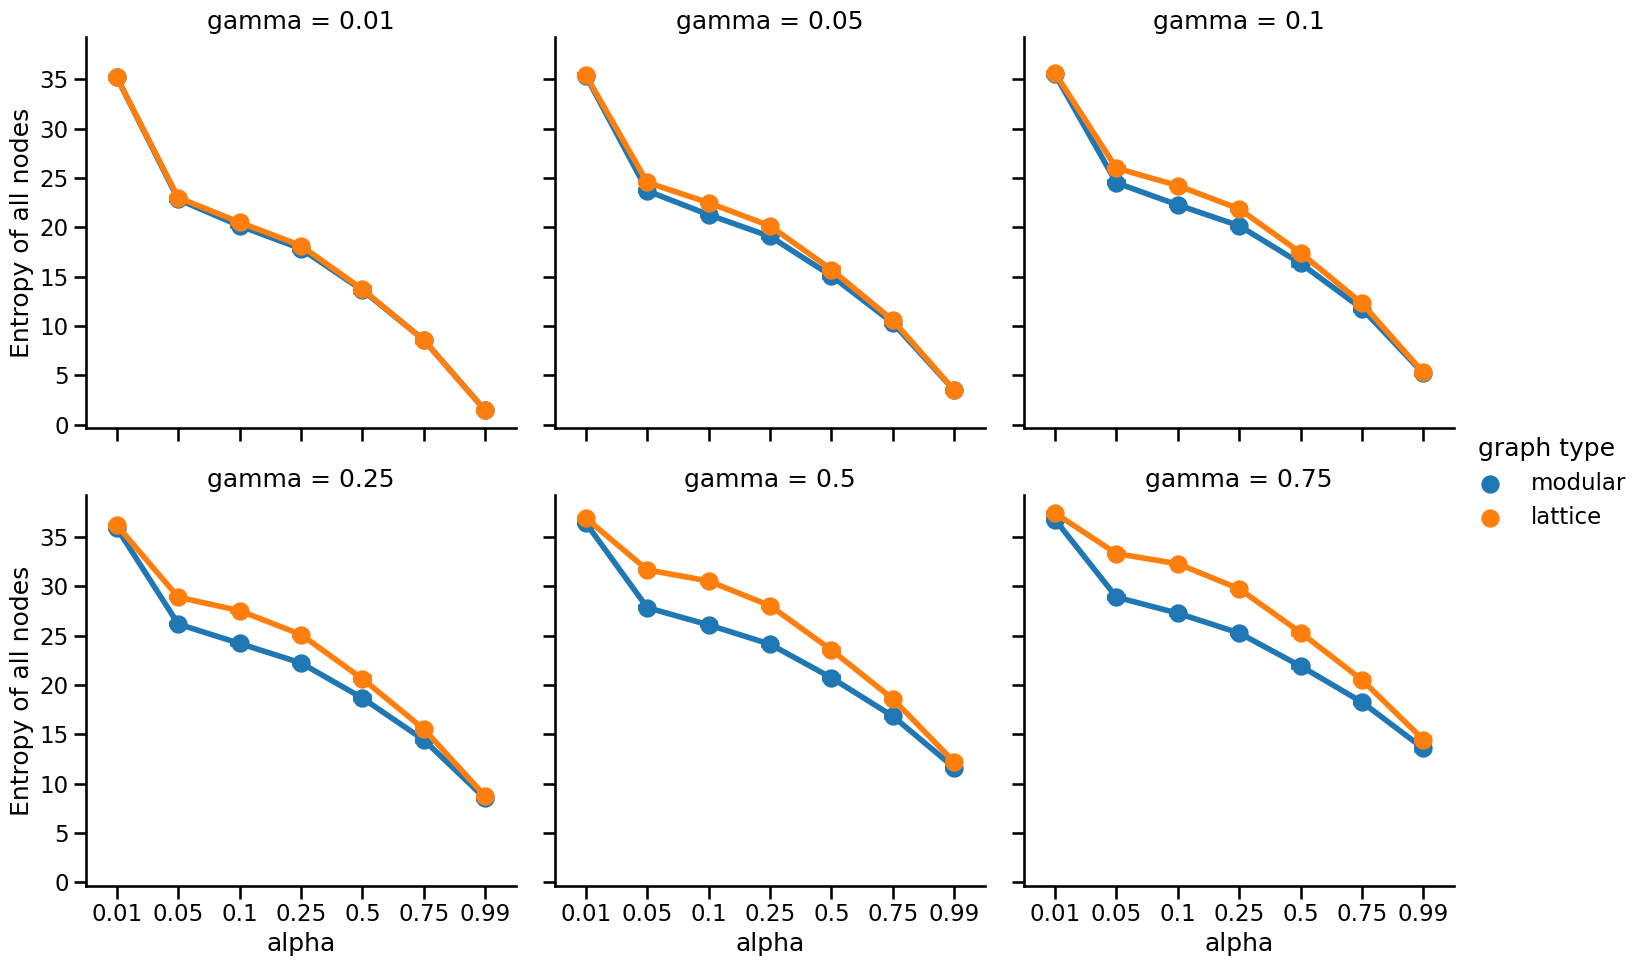

In [15]:
sns.set_context('talk')
g = sns.catplot(hue = 'graph type', x = 'alpha', y = 'entropy', col = 'gamma', 
                kind = 'point', capsize = 0.2, col_wrap = 3,
                data = df_entropy.loc[df_entropy['gamma'] != 0.99])
g.set_ylabels('Entropy of all nodes')
# g.set_titles('Boundary - Non Boundary Entropy')